# Wavelet-regularized pixelated source modeling
### Fit the source light as a regularised grid of pixels, assuming a fixed parametric lens (SIE + shear)
The true source is an elliptical Sérsic profile here, but can be anything.

__last updated__: 13/10/21

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
plt.rc('image', interpolation='none')

# Herculens imports
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter

# Universal font size
FS = 18

np.random.seed(18)

# Global settings
max_iterations = 300
init_learning_rate = 1e-2

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=FS, flux_vmin=5e-2, flux_vmax=7e-1, res_vmax=4)

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_grid = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_grid)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
exp_time = None
sigma_bkd = 0.05
noise_map = sigma_bkd * np.ones((npix, npix))
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Image model

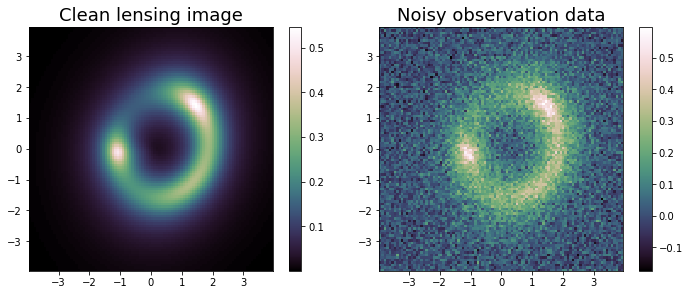

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

# Clean lens image
image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

# True source on data grid
source_true = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# 1D coordinate arrays for source grid interpolation
x_coords = lens_image.Grid.pixel_coordinates[0][0, :]
y_coords = lens_image.Grid.pixel_coordinates[1][:, 0]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', cmap=plotter.cmap_flux, extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', cmap=plotter.cmap_flux, extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Source fitting on a pixelated grid with starlet regularisation

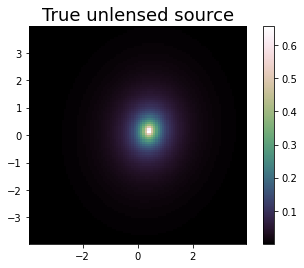

In [8]:
# Visualise the true source
fig, ax = plt.subplots(1, 1)
img = ax.imshow(source_true, origin='lower', cmap=plotter.cmap_flux, extent=extent)
ax.set_title("True unlensed source", fontsize=FS)
fig.colorbar(img)

### Create a model for fitting

In [9]:
# Recreate a Noise object with true noise map
kwargs_noise_fit = {'background_rms': sigma_bkd, 'noise_map': noise_map}
fit_noise = Noise(npix, npix, **kwargs_noise_fit)

# Uncomment this if using Poisson noise (i.e. exp_time not None)
#fit_noise.set_data(data)

# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.7,
    'grid_center': (kwargs_source_light[0]['center_x'], kwargs_source_light[0]['center_y']), 
    'grid_shape': (3.0, 3.6), # arcsec
}
fit_source_light_model = LightModel(fit_source_light_model_list,
                                    kwargs_pixelated=kwargs_pixelated_source)
fit_lens_image = LensImage(pixel_grid, psf, noise_class=fit_noise,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

In [10]:
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'pixels': 1e-5}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{}],
}
parameters = Parameters(fit_lens_image, kwargs_init, kwargs_fixed)

x_grid_lowres, y_grid_lowres = fit_lens_image.Grid.model_pixel_coordinates('source')
source_true_lowres = lens_image.SourceModel.surface_brightness(x_grid_lowres, y_grid_lowres,
                                                               kwargs_source_light)
source_true_lowres *= lens_image.Grid.pixel_area

kwargs_true = {
    'kwargs_lens': kwargs_lens_mass, 
    'kwargs_source': [{'pixels': source_true_lowres}]
}
p_true = parameters.kwargs2args(kwargs_true)
p_init = parameters.kwargs2args(kwargs_init)
print("truths:", len(p_true), parameters.names[0], parameters.names[-1])

truths: 3392 s_0 s_3391


### Loss function

In [11]:
loss = Loss(data, fit_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source'], 
            regularization_strengths=[3, 3, 3])

print("Loss at initial values:", loss(p_init))
print("Loss at true values:", loss(p_true))

Loss at initial values: 6.1131396
Loss at true values: 1.1228403


### Minimise the loss function using `optax`

In [12]:
optimizer = Optimizer(loss, parameters)

best_fit, logL, extra_fields_wt, runtime \
    = optimizer.optax(max_iterations=max_iterations, 
                      init_learning_rate=init_learning_rate,
                      restart_from_init=True)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))

Runtime: 23.136976957321167
Loss at best-fit: 1.1566929


In [13]:
kwargs_final = parameters.best_fit_values(as_kwargs=True)

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax-strong-lensing/herculens/Analysis/plot.py:127: UserWarning: True source array has been interpolated to match model array
  warnings.warn("True source array has been interpolated to match model array")


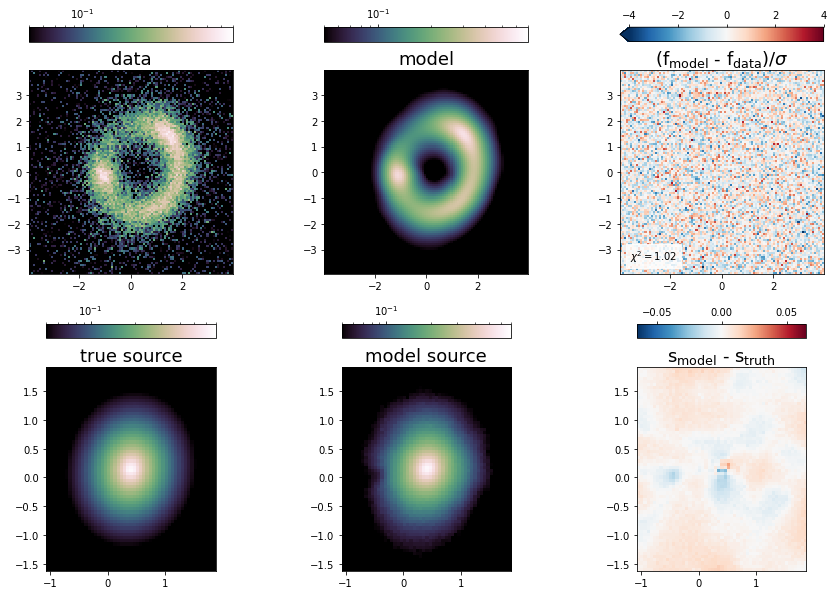

In [14]:
plotter.set_data(data)
plotter.set_true_source(source_true)
plotter.model_summary(fit_lens_image, kwargs_final)